In [1]:
import erroranalysis as ea
import numpy as np
from scipy.constants import k as k_b
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os,sys,glob
import numpy as np
import pimcscripts.pimchelp as pimchelp
import pimcscripts.MCstat as MCstat
from collections import defaultdict
import argparse 
import subprocess
import pickle

#from joblib import Parallel, delayed
import multiprocessing
directory_paths = {
    r'$N_g = 0$': '../data/raw/qmc_OUTPUT/NONovember12/',
    r'$N_g = 1$': '../data/raw/qmc_OUTPUT/FirstNovember12/',
    r'$N_g = 2$': '../data/raw/qmc_OUTPUT/SECONDNovember12/',
    r'$N_g = 3$':'../data/raw/qmc_OUTPUT/THIRDNovember12/',
    r'$N_g = \infty$':'../data/raw/qmc_OUTPUT/FULLNovember12/'
}
for key, value in directory_paths.items():
    print(f"Key: {key}, Value: {value}")

Key: $N_g = 0$, Value: ../data/raw/qmc_OUTPUT/NONovember12/
Key: $N_g = 1$, Value: ../data/raw/qmc_OUTPUT/FirstNovember12/
Key: $N_g = 2$, Value: ../data/raw/qmc_OUTPUT/SECONDNovember12/
Key: $N_g = 3$, Value: ../data/raw/qmc_OUTPUT/THIRDNovember12/
Key: $N_g = \infty$, Value: ../data/raw/qmc_OUTPUT/FULLNovember12/


In [2]:
#%run ~/.local/bin/merge.py -u -100 /lustre/isaac/scratch/gerwin2/local/pimc/build/OUTPUT/FULLSeptember3/
#directory_paths[r'$N_g = 0$']=value+'MERGED/'
print(directory_paths[r'$N_g = 0$'])

../data/raw/qmc_OUTPUT/NONovember12/


In [3]:
def compressibility(N,N2,volume=1.0,k_B=1.0,T=1.0):
    pf = 1/(volume*k_B*T)
    return pf*(((N2 - (N**2)))/1)
def heatcapacity(E,E2,k_B=1.0,T=1.0):
    pf = 1/(k_B*(T**2))
    return pf*(((E2 - (E**2))))

In [4]:
MERGED_files = True
if MERGED_files == False:
    folder_name = "MERGED"
    for key, value in directory_paths.items():
        directory = value
        if key == r'$N_g = 0$' or key == r'$N_g = \infty$':
            for i in range(-125, -14):
                %run ~/.local/bin/merge.py -u {i} {directory}
            #directory_paths[key]=value+'MERGED/'
    for key, value in directory_paths.items():
        directory = value
        if key == r'$N_g = 0$' or key == r'$N_g = \infty$':
            directory_paths[key]=value+'MERGED/'

In [5]:
for key, value in directory_paths.items():
    print(f"Key: {key}, Value: {value}")

Key: $N_g = 0$, Value: ../data/raw/qmc_OUTPUT/NONovember12/
Key: $N_g = 1$, Value: ../data/raw/qmc_OUTPUT/FirstNovember12/
Key: $N_g = 2$, Value: ../data/raw/qmc_OUTPUT/SECONDNovember12/
Key: $N_g = 3$, Value: ../data/raw/qmc_OUTPUT/THIRDNovember12/
Key: $N_g = \infty$, Value: ../data/raw/qmc_OUTPUT/FULLNovember12/


In [6]:
data={}
Analysis = False
pickle_file_path = '../data/data.pkl'

if Analysis == True:
    all_file_names = os.listdir('../data/QMC/NONovember12/MERGED/')
    gce_estimator_files = [f for f in all_file_names if f.startswith('gce-estimator-')]
    num = len(gce_estimator_files)-3
    box_volume = 14.757072880486835*17.04*10#\AA^3
    volume = box_volume
    temperature = 1 #K
    skip = 500
    for key, value in directory_paths.items():
        all_file_names = os.listdir(value)
        gce_estimator_files = [f for f in all_file_names if f.startswith('gce-estimator-')]
        gce_estimator_files = pimchelp.sortFileNames(gce_estimator_files)
        data[key] ={'u':np.zeros([num],float),'aveN':np.zeros([num],float),'errN':np.zeros([num],float),'aveKappa':np.zeros([num],float),'errKappa':np.zeros([num],float),'aveC':np.zeros([num],float),'errC':np.zeros([num],float)}
        for i in range(num):
            j=i+3
            headers = pimchelp.getHeadersFromFile(value+'/'+gce_estimator_files[j])
            param = pimchelp.getFileNameParameters(gce_estimator_files[j])
            chem = float(param[4])
            estData = np.loadtxt(value+'/'+gce_estimator_files[j],ndmin=2)
            N = estData[:,headers.index('N')]
            E = estData[:,headers.index('E')]
            boot = ea.bootstrap(N)
            data[key]['u'][i] = chem
            data[key]['aveN'][i] = boot[0]
            data[key]['errN'][i] = boot[1]
            κ_avg, κ_err = ea.bootstrap_on_function(compressibility,N[skip:],N[skip:]**2,volume=volume,k_B=1,T=temperature)
            data[key]['aveKappa'][i] = κ_avg
            data[key]['errKappa'][i] = κ_err
            C_avg, C_err = ea.bootstrap_on_function(heatcapacity,E,E**2,k_B=1,T=temperature)
            data[key]['aveC'][i] = C_avg
            data[key]['errC'][i] = C_err
            with open(pickle_file_path, 'wb') as file:
                pickle.dump(data, file)
with open(pickle_file_path, 'rb') as file:
    data = pickle.load(file)

In [7]:
print(data['$N_g = 0$']['u'][:])
print(data['$N_g = 0$']['aveN'][70:])

[-125. -124. -123. -122. -121. -120. -119. -118. -117. -116. -115. -114.
 -113. -112. -111. -110. -109. -108. -107. -106. -105. -104. -103. -102.
 -101. -100.  -99.  -98.  -97.  -96.  -95.  -94.  -93.  -92.  -91.  -90.
  -89.  -88.  -87.  -86.  -85.  -84.  -83.  -82.  -81.  -80.  -79.  -78.
  -77.  -76.  -75.  -74.  -73.  -72.  -71.  -70.  -69.  -68.  -67.  -66.
  -65.  -64.  -63.  -62.  -61.  -60.  -59.  -58.  -57.  -56.  -55.  -54.
  -53.  -52.  -51.  -50.  -49.  -48.  -47.  -46.  -45.  -44.  -43.  -42.
  -41.  -40.  -39.  -38.  -37.  -36.  -35.  -34.  -33.  -32.  -31.  -30.
  -29.  -28.  -27.  -26.  -25.  -24.  -23.  -22.  -21.  -20.  -19.  -18.
  -17.  -16.  -15.]
[25.04156546 24.21220768 27.99777192 27.99934024 25.         27.97475758
 25.01066514 27.99739531 27.99989737 28.         27.99992186 28.
 25.         28.         28.         28.         28.         28.00000013
 28.00000472 28.00000689 28.00003889 28.00010657 28.00019146 28.00060857
 28.00165797 28.00472668 28.01312161 28

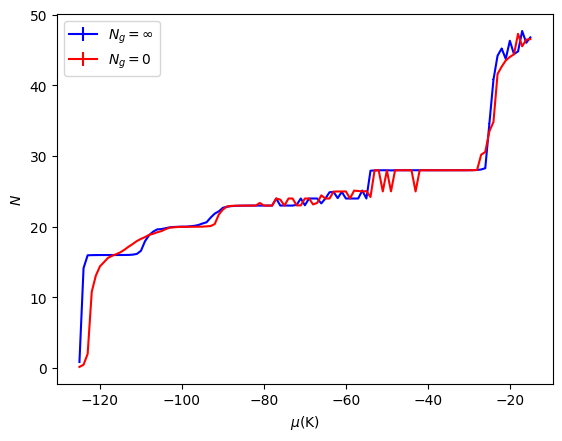

In [8]:
#plt.rcParams.update(plt.rcParamsDefault)
plt.errorbar(data[r'$N_g = \infty$']['u'],data[ r'$N_g = \infty$']['aveN'],yerr=data[ r'$N_g = \infty$']['errN'],color='blue',label=r'$N_g = \infty$')
#plt.errorbar(data[r'$N_g = 1$']['u'],data[ r'$N_g = 1$']['aveN'],yerr=data[ r'$N_g = 1$']['errN'],color='black',label=r'$N_g = 3$')
plt.errorbar(data[ r'$N_g = 0$']['u'],data[ r'$N_g = 0$']['aveN'],yerr=data[ r'$N_g = 0$']['errN'],color='red',label=r'$N_g = 0$')

plt.ylabel(r'$N$',fontsize=10)
plt.xlabel(r'$\mu$(K)',fontsize=10)
#plt.xlim(-40,-15)
#plt.ylim(25,50)
plt.legend(loc='upper left')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


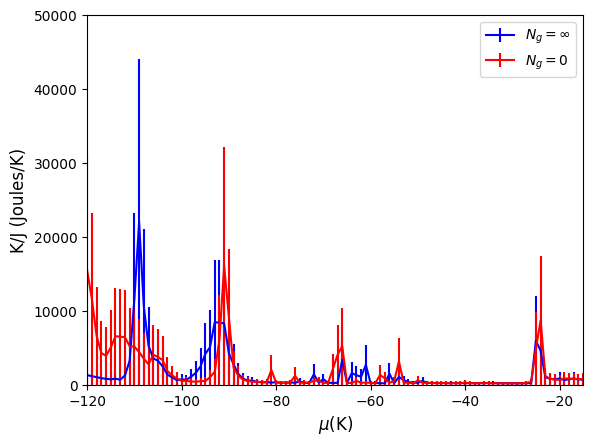

In [9]:
#plt.rcParams.update(plt.rcParamsDefault)
plt.errorbar(data[r'$N_g = \infty$']['u'],data[ r'$N_g = \infty$']['aveC'],yerr=data[ r'$N_g = \infty$']['aveC'],color='blue',label=r'$N_g = \infty$')
#plt.errorbar(data[ r'$N_g = 3$']['u'],data[ r'$N_g = 3$']['aveC'],yerr=data[ r'$N_g = 3$']['aveC'],color='green')
#plt.errorbar(data[ r'$N_g = 2$']['u'],data[ r'$N_g = 2$']['aveC'],yerr=data[ r'$N_g = 2$']['aveC'],color='black')
#plt.errorbar(data[ r'$N_g = 1$']['u'],data[ r'$N_g = 1$']['aveC'],yerr=data[ r'$N_g = 1$']['aveC'],color='orange')

plt.errorbar(data[ r'$N_g = 0$']['u'],data[ r'$N_g = 0$']['aveC'],yerr=data[ r'$N_g = 0$']['aveC'],color='red',label=r'$N_g = 0$')
plt.ylim(0,5e4)
plt.xlim(-120,-15)
plt.ylabel(r'K/J (Joules/K)',fontsize=12)
plt.xlabel(r'$\mu$(K)',fontsize=12)
plt.legend(loc='upper right')
plt.savefig('../figures/Fig8.eps', format='eps')

plt.show()

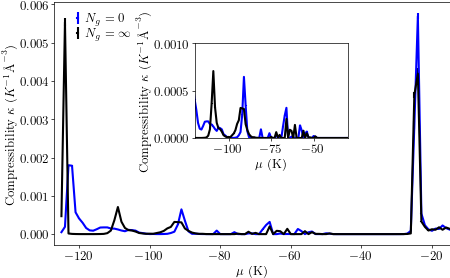

In [10]:
import matplotlib.pyplot as plt
plot_style = {'aps':'aps.mplstyle'}
plt.style.reload_library()
plt.style.use(plot_style['aps'])

blue_color = (0, 0, 1)      
black_color = (0, 0, 0)

fig = plt.figure(figsize=(8.5*.6, 5.253*.6))
# Plot with error bars and custom RGB colors
plt.errorbar(data[r'$N_g = 0$']['u'], data[r'$N_g = 0$']['aveKappa'], yerr=data[r'$N_g = 0$']['errKappa'], color=blue_color, label=r'$N_g = 0$')
plt.errorbar(data[r'$N_g = \infty$']['u'], data[r'$N_g = \infty$']['aveKappa'], yerr=data[r'$N_g = \infty$']['errKappa'], color=black_color, label=r'$N_g = \infty$')
plt.xlim(-127, -15)
#plt.ylim(0, 0.001)
plt.ylabel(r'Compressibility $\kappa$ $(K^{-1}\textrm{\AA}^{-3})$')
plt.xlabel(r'$\mu$ (K)')
plt.legend(loc='upper left',bbox_to_anchor=(.03, 1), ncol=1)

axins = plt.axes([0.40, 0.45, 0.3, 0.3])  # (left, bottom, width, height)

# Plot the data in the inset
axins.errorbar(data[r'$N_g = 0$']['u'], data[r'$N_g = 0$']['aveKappa'], yerr=data[r'$N_g = 0$']['errKappa'], color=blue_color, label=r'$N_g = 0$')
axins.errorbar(data[r'$N_g = \infty$']['u'], data[r'$N_g = \infty$']['aveKappa'], yerr=data[r'$N_g = \infty$']['errKappa'], color=black_color, label=r'$N_g = \infty$')
axins.set_xlim(-120, -30)
axins.set_ylim(0, 0.001)

# Customize the inset appearance
axins.set_xlabel(r'$\mu$ (K)')
axins.set_ylabel(r'Compressibility $\kappa$ $(K^{-1}\textrm{\AA}^{-3})$')
plt.savefig('../figures/Fig4.svg', format='svg')
plt.savefig('../figures/Fig4.pdf', format='pdf')
